<a href="https://colab.research.google.com/github/hedzd/HepaticVessel/blob/main/HepaticVessels_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image segmentation for hepatic vessels tumors

About the dataset:
This liver dataset was comprised of patients
with a variety of primary and metastatic liver tumours (cholangiocarcinoma,
hepatocellular carcinoma, metastases, etc.) 
Four hundred and forty-three portal venous phase CT scans were obtained
The liver vessels were semi-automatically
segmented. Contours were manually adjusted by an expert abdominal radiologist.

Get the dataset
http://medicaldecathlon.com/

labels: {'0': 'background', '1': 'Vessel', '2': 'Tumour'}\
total number of samples with masks: 303

# Image segmentation for hepatic vessels tumors


*   Create a Custom Dataset for training and testing
*   Use albumentations transforms to pre-process data
*   Train the model with a PyTorch program
*   Evaluate on test dataset
*   Use Segmentation-Models Module
*   Use Unet(with ResNet18 BackBone)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
from pathlib import Path
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import nibabel as nib
from scipy.ndimage import gaussian_filter as gf
from scipy import ndimage

# Extract .tar data into the hepaticData

In [ ]:
!mkdir HepaticData

In [ ]:
!tar -xvf  '/content/drive/MyDrive/Task08_HepaticVessel.tar' -C 'HepaticData'

./._Task08_HepaticVessel
Task08_HepaticVessel/
Task08_HepaticVessel/._labelsTr
Task08_HepaticVessel/labelsTr/
Task08_HepaticVessel/._imagesTr
Task08_HepaticVessel/imagesTr/
Task08_HepaticVessel/._imagesTs
Task08_HepaticVessel/imagesTs/
Task08_HepaticVessel/._dataset.json
Task08_HepaticVessel/dataset.json
Task08_HepaticVessel/imagesTs/._hepaticvessel_306.nii.gz
Task08_HepaticVessel/imagesTs/hepaticvessel_306.nii.gz
Task08_HepaticVessel/imagesTs/._hepaticvessel_457.nii.gz
Task08_HepaticVessel/imagesTs/hepaticvessel_457.nii.gz
Task08_HepaticVessel/imagesTs/._hepaticvessel_365.nii.gz
Task08_HepaticVessel/imagesTs/hepaticvessel_365.nii.gz
Task08_HepaticVessel/imagesTs/._hepaticvessel_426.nii.gz
Task08_HepaticVessel/imagesTs/hepaticvessel_426.nii.gz
Task08_HepaticVessel/imagesTs/._hepaticvessel_377.nii.gz
Task08_HepaticVessel/imagesTs/hepaticvessel_377.nii.gz
Task08_HepaticVessel/imagesTs/._hepaticvessel_277.nii.gz
Task08_HepaticVessel/imagesTs/hepaticvessel_277.nii.gz
Task08_HepaticVessel/i

In [ ]:
!rm -r /content/HepaticData/Task08_HepaticVessel/imagesTs
!rm -r /content/HepaticData/Task08_HepaticVessel/dataset.json

# Prepare Data format with below format and structure:
1. Creating 2 sub-folder: **imagesTr and labelsTr** (for train and validation set)
2. Transforming 3D data to 2D slices and save with npz format(for example 05_23.npz In such a way that the first number indicates the subject number and the second number indicates the slice number) with array name -> img 
3. The images are in the imagesTr folder
4. The segmentation masks are in the labelsTr folder


In [ ]:
!mkdir /content/drive/MyDrive/2D-data

In [ ]:
!mkdir /content/drive/MyDrive/2D-data/imagesTr
!mkdir /content/drive/MyDrive/2D-data/labelsTr

In [ ]:
imageTrPath = '/content/HepaticData/Task08_HepaticVessel/imagesTr/'
imgPathlist = Path(imageTrPath).glob('hepaticvessel_*.gz')
num = 1
for filename in imgPathlist:
  img  = nib.load(filename)
  nii_data = np.rot90(img.get_fdata(),3, axes=(1,0))
  # nii_data[nii_data<-1024]=-1024
  print(filename , '-',nii_data.shape)

  maskFileName = str(filename).replace("images", "labels")
  img  = nib.load(maskFileName)
  nii_mask = np.rot90(img.get_fdata(),3, axes=(1,0))
  for j in range(nii_mask.shape[2]):
    img0 = np.array(np.round(nii_data[:,:,j],0),dtype='int16')
    mask0 = np.array(nii_mask[:,:,j],dtype='int16')

    np.savez_compressed('/content/drive/MyDrive/2D-data/imagesTr/' + str(num).zfill(3)+ '_' +str(j).zfill(3)+'.npz',img=img0 )
    np.savez_compressed('/content/drive/MyDrive/2D-data/labelsTr/' + str(num).zfill(3)+ '_' +str(j).zfill(3)+'.npz',img=mask0)
  num += 1
    

/content/HepaticData/Task08_HepaticVessel/imagesTr/hepaticvessel_174.nii.gz - (512, 512, 32)
/content/HepaticData/Task08_HepaticVessel/imagesTr/hepaticvessel_384.nii.gz - (512, 512, 158)
/content/HepaticData/Task08_HepaticVessel/imagesTr/hepaticvessel_112.nii.gz - (512, 512, 44)
/content/HepaticData/Task08_HepaticVessel/imagesTr/hepaticvessel_287.nii.gz - (512, 512, 164)
/content/HepaticData/Task08_HepaticVessel/imagesTr/hepaticvessel_117.nii.gz - (512, 512, 53)
/content/HepaticData/Task08_HepaticVessel/imagesTr/hepaticvessel_291.nii.gz - (512, 512, 143)
/content/HepaticData/Task08_HepaticVessel/imagesTr/hepaticvessel_084.nii.gz - (512, 512, 45)
/content/HepaticData/Task08_HepaticVessel/imagesTr/hepaticvessel_321.nii.gz - (512, 512, 37)
/content/HepaticData/Task08_HepaticVessel/imagesTr/hepaticvessel_057.nii.gz - (512, 512, 38)
/content/HepaticData/Task08_HepaticVessel/imagesTr/hepaticvessel_341.nii.gz - (512, 512, 49)
/content/HepaticData/Task08_HepaticVessel/imagesTr/hepaticvessel_34

In [ ]:
import shutil
shutil.make_archive('/content/drive/MyDrive/2D-data',
                    'zip',
                    '/content/drive/MyDrive/',
                    '2D-data')

'/content/drive/MyDrive/2D-data.zip'

Now we have our 2D dataset in a .zip file in our google drive, next time we can only run the code below to load our dataset

### Import 2D data, choose 50 samples, change masks from multiclass to one tumor class 

In [ ]:
import shutil
shutil.unpack_archive("/content/drive/MyDrive/2D-data.zip", "2D-data")

In [ ]:
!mkdir partOfData

In [ ]:
!mkdir /content/partOfData/imagesTr
!mkdir /content/partOfData/labelsTr

In [ ]:
imgPathTr = '/content/2D-data/2D-data/imagesTr'
imgPathlist = Path(imgPathTr).glob('*.npz')
for filename in imgPathlist:
  s1 = str(filename).split('/')[5]
  s2 = s1.split('_')[0]
  s3 = s1.split('_')[1].split('.')[0]
  if int(s2) <= 100:
    maskFileName = str(filename).replace("images", "labels")
    mask0 =np.load(maskFileName)['img']
    img0 = np.load(filename)['img']
    #assuming vessels as background
    mask0[mask0 != 2] = 0
    mask0[mask0 == 2] = 1
    np.savez_compressed('/content/partOfData/imagesTr/' + s2 + '_' +s3+'.npz',img=img0)
    np.savez_compressed('/content/partOfData/labelsTr/' + s2 + '_' +s3+'.npz',img=mask0)

### Checking pixel Values to set "window" function input arguements

In [ ]:
imgPathTr = '/content/partOfData/imagesTr'
imgPathlist = Path(imgPathTr).glob('*.npz')
pixel_values = []
for filename in imgPathlist:
  maskFileName = str(filename).replace("images", "labels")
  mask =np.load(maskFileName)['img']
  # print(mask)
  img = np.load(filename)['img']
  for i in range(512):
    for j in range(512):
      if mask[i][j] == 1:
        pixel_values.append(img[i][j])

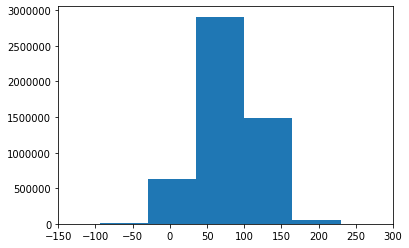

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(pixel_values,bins = 50)
plt.xlim([-150, 300])
ax.ticklabel_format(style='plain')
plt.show()

In [ ]:
import statistics
std_pixel_values = np.std(pixel_values)
mean_pixel_values = statistics.mean(pixel_values)
print(std_pixel_values)
print(mean_pixel_values)

43.94551500321988
81


#Install segmentation-models-pytorch

In [ ]:
# !pip -q install monai
# !pip -q install 'monai[all]'
# !pip install segmentation-models-pytorch
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-2vp5e0g0
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-2vp5e0g0
     |████████████████████████████████| 61kB 4.4MB/s 
     |████████████████████████████████| 245kB 16.8MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.3-cp37-none-any.whl size=83178 sha256=b6c772a97f87270809e1e4330c1216a1fcaaeb2545e0459a21c85df54829891f
  Stored in directory: /tmp/pip-ephem-wheel-cache-4at8t_vj/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60966 sha256=21b0f41dd5844896d982de2b060bbe11e4c5d901a3951df10bccb6dceabeab96
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-no

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.torch import ToTensor

import sys
import glob

def window(img, mean=81, std=44):
    upper, lower = mean+3*std, mean-3*std
    X = np.clip(img.copy(), lower, upper)
    X = X - np.min(X)
    X = X / (np.max(X)/255.0)
    X = cv2.merge([X,X,X])
    X = X.astype('uint8')
    return X

%matplotlib inline
np.random.seed(0)
# print_config()

## Random Split and Set dataset path

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

train_subject,test_subject = train_test_split(np.arange(1,101,1), test_size=0.2, random_state=0)

train_slices = []

for i in train_subject:
  train_slices += glob.glob(f'/content/partOfData/imagesTr/'+str(i).zfill(3)+'*.npz')

test_slices = []
for i in test_subject:
  test_slices += glob.glob(f'/content/partOfData/labelsTr/'+str(i).zfill(3)+'*.npz')
test_slices = sorted(test_slices)
len(train_slices),len(test_slices)

(5216, 1524)

# Show a sample slice

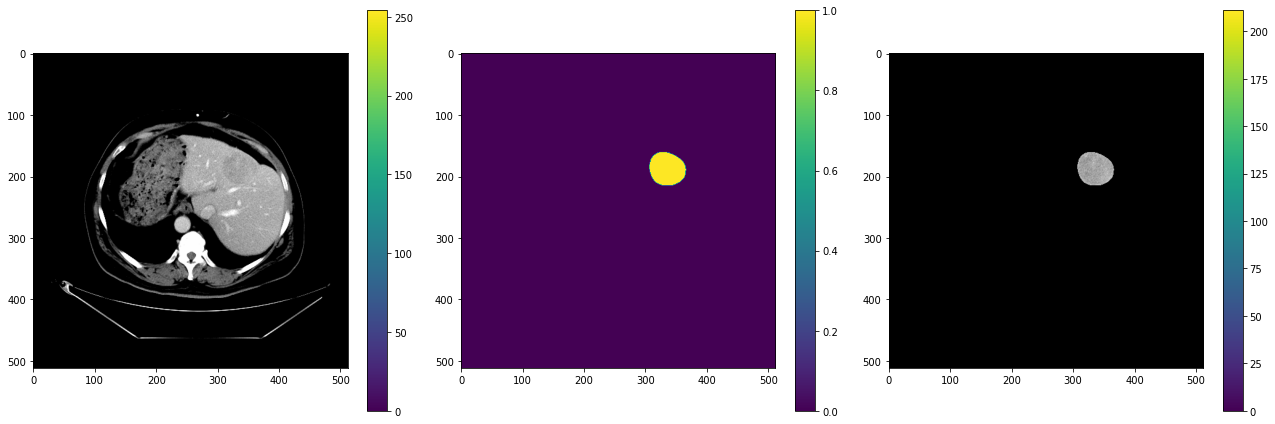

In [ ]:
i = 280

img = np.load(train_slices[i])['img']

mask =np.load(train_slices[i].replace('imagesTr','labelsTr'))['img']


slice_img = window(img)
slice_mask = mask
masked = np.array(slice_img)

masked[slice_mask==0]=0

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(slice_img)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(slice_mask)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(masked)
plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
def get_transforms(phase, size, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(),
                ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=10, # rotate
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT
                ),
#                 GaussNoise(),
            ]
        )
    list_transforms.extend(
        [
            Resize(size, size),
            Normalize(mean=mean, std=std, p=1),
            ToTensor()
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

class CustomDataSet(Dataset):
    def __init__(self, files_list, size, mean, std, phase):
        self.size = size
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, size, mean, std)
        self.fnames = files_list

    def __getitem__(self, idx):
        image_path = self.fnames[idx]
        image = window(np.load(image_path)['img'])
        image = image.astype(float)
        mask = np.load(image_path.replace('imagesTr','labelsTr'))['img']
        mask = mask.astype(float)

        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask

    def __len__(self):
        return len(self.fnames)


phase = 'train'
size=256
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)
batch_size=16
num_workers=1

train_ds = CustomDataSet(train_slices, size, mean, std, phase)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=num_workers)

phase='test'
val_ds = CustomDataSet(test_slices, size, mean, std, phase)
val_loader = DataLoader(val_ds, batch_size=16, num_workers=num_workers)

for batch_data in train_loader:
  print(type(batch_data))
  break

<class 'list'>


In [ ]:
# mask = np.load('/content/partOfData/labelsTr/001_014.npz')['img']

In [ ]:
# plt.hist(mask.flatten())

In [ ]:
# np.unique(y_true)

In [ ]:
# (y_true == 1).sum() / len(y_true.flatten()) 

0.005040646850906332

# Show slices with infection segmentation in a random batch-data

In [ ]:
batch = next(iter(train_loader)) 
images, masks = batch

for idx in range(8):
  if len(np.unique(masks[idx][0])) > 1:
    plt.subplot(1,2,1)
    plt.imshow(images[idx][0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(images[idx][0], cmap='bone')
    plt.imshow(masks[idx][0], alpha=0.5, cmap='Reds')
    plt.show()

## Create Model
- standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
- use segmentation_models_pytorch 
- import unet with encoder 'resnet18'
- use 'imagenet' encoder weights
- input has 3 channels and output has 1 channel(use sigmoid activation layer for last layer)

In [ ]:
try:
  device = torch.device("cuda:0")
  print('run with gpu')
except:
  device = torch.device("cpu")

import segmentation_models_pytorch as smp
n_classes = 1
activation = 'sigmoid' if n_classes == 1 else 'softmax'
model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    activation=activation
).to(device)

# print(model)

run with gpu


# Loss and Optimizer
- Loss = BCE + Dice_loss
- Optimizer = Adam with initial_lr = 1e-3
- lr_scheduler with CosineAnnealingLR for lr decay

In [ ]:
bce_loss = torch.nn.BCELoss()

def dice_loss(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return  1 - (numerator + 1) / (denominator + 1)

def bce_dice_loss(pred,target):
  return bce_loss(pred,target) + dice_loss(pred,target)

loss_function = bce_dice_loss

optimizer = torch.optim.Adam(model.parameters(), 1e-3,weight_decay=0)

epoch_num = 20
val_interval = 1

steps = epoch_num#int(len(train_slices)/batch_size)+1
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)

# Define custom metric

In [ ]:
from torch.autograd import Variable

def my_dice(y_pred,y_true,device='cpu',thr=0.5):
    thr = Variable(torch.Tensor([thr])).to(device)  
    y_pred = (y_pred > thr).float() * 1
    smooth = 1e-4
    iflat = y_pred.view(-1)
    tflat = y_true.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

# Execute a typical PyTorch training process

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:

        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = 1+(len(train_ds) // train_loader.batch_size)

        sys.stdout.write('\r'+f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    print('\n',f"###### epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            dice_metric = my_dice(y_pred, y,device=device,thr=0.5)
            metric_values.append(dice_metric)
            if dice_metric > best_metric:
                best_metric = dice_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('###### Congratulations ###### saved new best metric model')
            print(f"current epoch: {epoch + 1} current DICE: {dice_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
        scheduler.step()
        print('The learning rate updated to :',scheduler.get_lr()[0])
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/20
326/327, train_loss: 1.0058
 ###### epoch 1 average loss: 0.9469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


###### Congratulations ###### saved new best metric model
current epoch: 1 current DICE: 0.0000 at epoch: 1
The learning rate updated to : 0.000987726234834463
----------
epoch 2/20


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


326/327, train_loss: 0.3086
 ###### epoch 2 average loss: 0.8088


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


current epoch: 2 current DICE: 0.0000 at epoch: 1
The learning rate updated to : 0.0009575498965391206
----------
epoch 3/20
326/327, train_loss: 0.3773
 ###### epoch 3 average loss: 0.6855


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


###### Congratulations ###### saved new best metric model
current epoch: 3 current DICE: 0.0003 at epoch: 3
The learning rate updated to : 0.0009164023811348203
----------
epoch 4/20
326/327, train_loss: 0.4533
 ###### epoch 4 average loss: 0.6481


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


current epoch: 4 current DICE: 0.0000 at epoch: 3
The learning rate updated to : 0.0008652911674490296
----------
epoch 5/20
326/327, train_loss: 0.6018
 ###### epoch 5 average loss: 0.5953


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


current epoch: 5 current DICE: 0.0000 at epoch: 3
The learning rate updated to : 0.000805468818544741
----------
epoch 6/20
326/327, train_loss: 0.8712
 ###### epoch 6 average loss: 0.5945


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


current epoch: 6 current DICE: 0.0000 at epoch: 3
The learning rate updated to : 0.0007384019661749497
----------
epoch 7/20
326/327, train_loss: 0.6248
 ###### epoch 7 average loss: 0.5838


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


current epoch: 7 current DICE: 0.0000 at epoch: 3
The learning rate updated to : 0.0006657349821962692
----------
epoch 8/20
326/327, train_loss: 0.5873
 ###### epoch 8 average loss: 0.5587


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


current epoch: 8 current DICE: 0.0000 at epoch: 3
The learning rate updated to : 0.0005892492048157691
----------
epoch 9/20
326/327, train_loss: 1.0043
 ###### epoch 9 average loss: 0.5074


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


current epoch: 9 current DICE: 0.0000 at epoch: 3
The learning rate updated to : 0.0005108186821407395
----------
epoch 10/20
326/327, train_loss: 0.4942
 ###### epoch 10 average loss: 0.4983


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


current epoch: 10 current DICE: 0.0000 at epoch: 3
The learning rate updated to : 0.0004323634543204362
----------
epoch 11/20
326/327, train_loss: 0.1747
 ###### epoch 11 average loss: 0.4988


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


current epoch: 11 current DICE: 0.0000 at epoch: 3
The learning rate updated to : 0.00035580140588598096
----------
epoch 12/20
326/327, train_loss: 0.2479
 ###### epoch 12 average loss: 0.4979


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


current epoch: 12 current DICE: 0.0000 at epoch: 3
The learning rate updated to : 0.00028299965697709667
----------
epoch 13/20
326/327, train_loss: 1.0072
 ###### epoch 13 average loss: 0.4789


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


current epoch: 13 current DICE: 0.0000 at epoch: 3
The learning rate updated to : 0.00021572627108606626
----------
epoch 14/20
326/327, train_loss: 0.1686
 ###### epoch 14 average loss: 0.4331


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


current epoch: 14 current DICE: 0.0000 at epoch: 3
The learning rate updated to : 0.00015560260228670536
----------
epoch 15/20
326/327, train_loss: 0.5877
 ###### epoch 15 average loss: 0.4186


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


current epoch: 15 current DICE: 0.0000 at epoch: 3
The learning rate updated to : 0.00010405551730498958
----------
epoch 16/20
326/327, train_loss: 0.4486
 ###### epoch 16 average loss: 0.4314


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


current epoch: 16 current DICE: 0.0000 at epoch: 3
The learning rate updated to : 6.226588069423686e-05
----------
epoch 17/20
326/327, train_loss: 0.5818
 ###### epoch 17 average loss: 0.3852


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


current epoch: 17 current DICE: 0.0000 at epoch: 3
The learning rate updated to : 3.1101138372550884e-05
----------
epoch 18/20
326/327, train_loss: 0.6638
 ###### epoch 18 average loss: 0.3867


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


current epoch: 18 current DICE: 0.0000 at epoch: 3
The learning rate updated to : 1.0989027459343206e-05
----------
epoch 19/20
326/327, train_loss: 0.2357
 ###### epoch 19 average loss: 0.3824


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


current epoch: 19 current DICE: 0.0000 at epoch: 3
The learning rate updated to : 1.5484896642770641e-06
----------
epoch 20/20
326/327, train_loss: 0.2686
 ###### epoch 20 average loss: 0.3904


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


current epoch: 20 current DICE: 0.0000 at epoch: 3
The learning rate updated to : 0.0
train completed, best_metric: 0.0003 at epoch: 3
current epoch: 20 current DICE: 0.0000 at epoch: 3
The learning rate updated to : 0.0
train completed, best_metric: 0.0003 at epoch: 3


## Plot the loss and metric

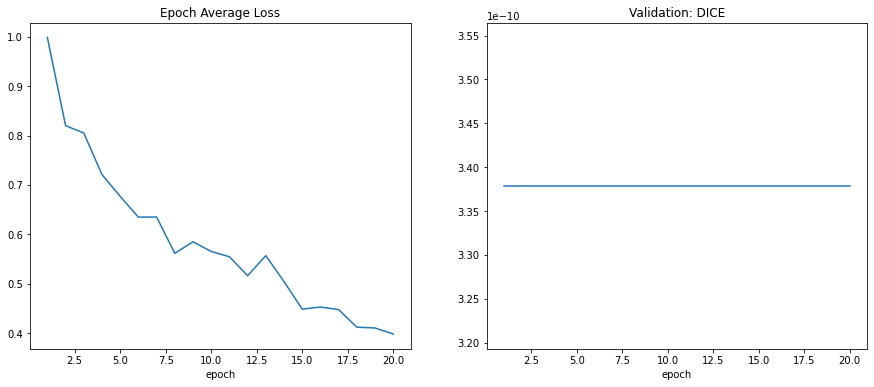

In [ ]:
plt.figure('train', (15, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: DICE")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

## Check best model output with the input slice and label

In [ ]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()
# y_new_pred = list()
with torch.no_grad():
    for val_data in val_loader:
        test_images, test_labels = val_data[0].to(device), val_data[1].to(device)
        pred = model(test_images)
        # new_pred = pred.argmax(dim=1)

        for i in range(len(pred)):
            y_true.append(test_labels[i].cpu().detach().numpy())
            y_pred.append(pred[i].cpu().detach().numpy())
            # y_new_pred.append(new_pred[i].cpu().detach().numpy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true.shape,y_pred.shape

((1524, 1, 256, 256), (1524, 1, 256, 256))

In [ ]:
y_true.shape,y_pred.shape

((1524, 1, 256, 256), (1524, 1, 256, 256))

          Raw Images        ,       True Mask(green)      ,   Prediction Mask(Red)


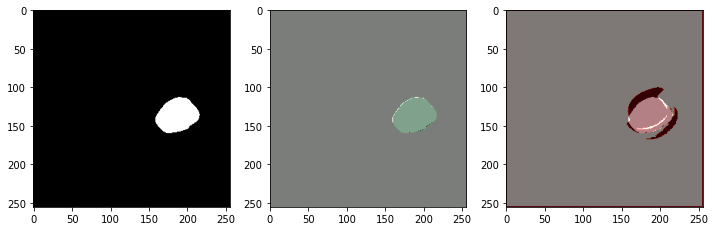

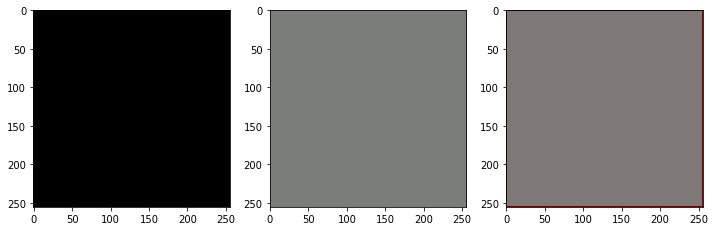

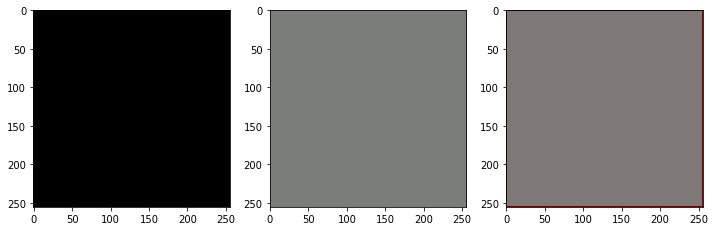

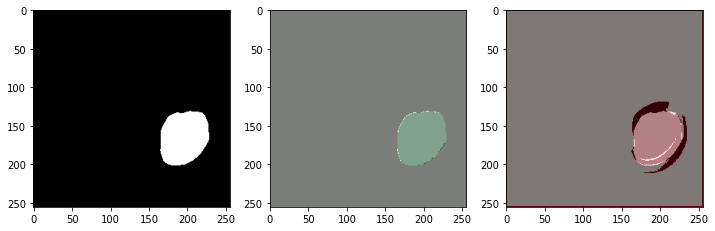

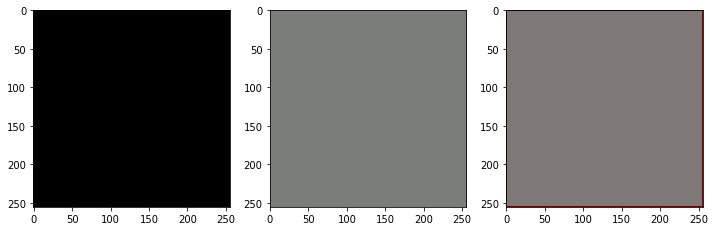

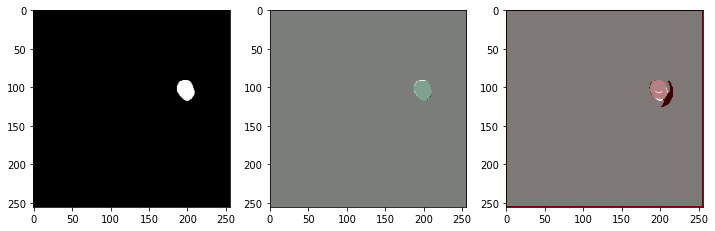

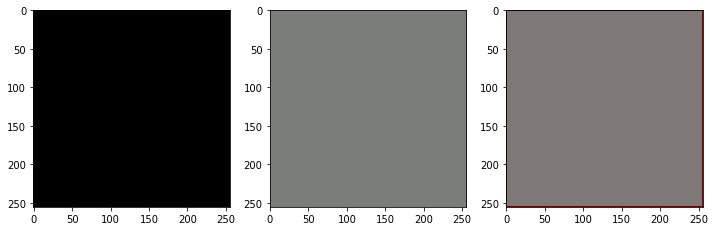

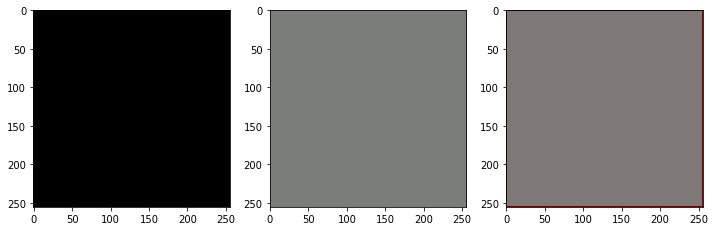

In [ ]:
n_sample = 8

samples = np.random.randint(0,1524,n_sample)

images, masks, predict = [],[],[]
for sample in samples:
  images.append(cv2.resize(np.load(np.array(test_slices)[sample])['img'],(size,size)))
  masks.append(y_true[sample,0])
  predict.append(y_pred[sample,0]>0.5)

print('          Raw Images        ,       True Mask(green)      ,   Prediction Mask(Red)')
for idx in range(n_sample):
  if np.sum(masks[idx])+np.sum(predict[idx]) > 10:
    plt.figure(figsize=(12,36))
    plt.subplot(1,3,1)
    plt.imshow(images[idx], cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(images[idx], cmap='gray')
    plt.imshow(masks[idx], alpha=0.5, cmap='Greens')
    plt.subplot(1,3,3)
    plt.imshow(images[idx], cmap='gray')
    plt.imshow(predict[idx], alpha=0.5, cmap='Reds')
    plt.show()

In [ ]:
def my_dice_np(y_pred,y_true,device='cpu',thr=0.00001):
    y_pred = (y_pred > thr).astype(float) * 1
    smooth = 1e-4
    iflat = y_pred.flatten()
    tflat = y_true.flatten()
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [ ]:
my_dice_np(y_pred,y_true)

0.33895813586262646

(0.01, 0.1)

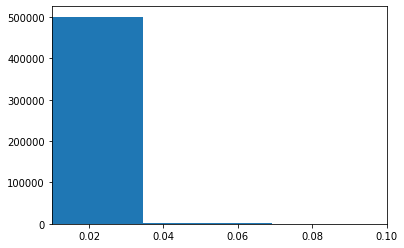

In [ ]:
plt.hist(y_pred[y_true == 1].flatten(), bins = 20)
plt.xlim(0.01,0.1)

(array([99373420.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,   503444.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

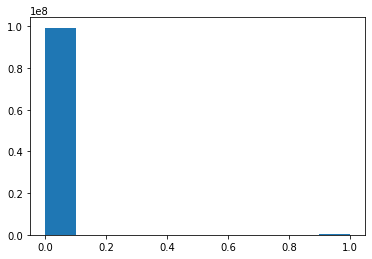

In [ ]:
plt.hist(y_true.flatten())